In [148]:
dataset = 'pubmed'
n_sample = 19717
size = 4
if size == 4:
    dim = 2560
elif size == 0.6:
    dim = 1024
    size = 0.6
else:
    dim = 4096

In [149]:
import numpy as np

N, D = n_sample, dim   # ← whatever your total count and embedding dim are
sample_embs = np.memmap(
    f"{dataset}/center_{size}B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
sample_embs = np.array(sample_embs)
sample_embs[-1]

array([-6.0554058e-04,  5.5575430e-02, -3.8726053e-03, ...,
        1.4384700e-03,  7.5403041e-05, -2.1546733e-02], dtype=float32)

In [150]:
import torch
data = torch.load(f'{dataset}/processed_data.pt')

In [151]:
# import numpy as np

# N, D = n_sample, dim   # ← whatever your total count and embedding dim are
# sample_mp_embs = np.memmap(
#     f"{dataset}/_mp_{size}B_embeddings.npy",
#     dtype="float32",
#     mode="r",
#     shape=(N, D)
# )
# sample_mp_embs = np.array(sample_mp_embs)
# sample_mp_embs[-1]

In [152]:
import numpy as np

N, D = n_sample, dim   # ← whatever your total count and embedding dim are
sample_mp_embs = np.memmap(
    f"{dataset}/shuffle_seed42_concat_4B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
sample_mp_embs = np.array(sample_mp_embs)
sample_mp_embs[-1]

array([-0.0005983 ,  0.03499336, -0.02626722, ...,  0.02484497,
        0.0059143 , -0.00855307], dtype=float32)

In [154]:
import numpy as np

N, D = n_sample, dim   # ← whatever your total count and embedding dim are
sample_mp_context_embs = np.memmap(
    f"{dataset}/_instruct_mp_context_{size}B_embeddings.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
sample_mp_context_embs = np.array(sample_mp_context_embs)
sample_mp_context_embs[-1]

array([-0.00063237,  0.0423477 , -0.02295643, ...,  0.02072941,
        0.00581864, -0.01233335], dtype=float32)

In [155]:
# import numpy as np

# N, D = n_sample, dim   # ← whatever your total count and embedding dim are
# sample_concat_embs = np.memmap(
#     f"{dataset}/concat_{size}B_embedding_0.npy",
#     dtype="float32",
#     mode="r",
#     shape=(N, D)
# )
# sample_concat_embs = np.array(sample_concat_embs)
# sample_concat_embs[-1]

In [156]:
import numpy as np

N, D = n_sample, dim   # ← whatever your total count and embedding dim are
sample_concat_embs = np.memmap(
    f"{dataset}/shuffle_seed0_concat_4B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
sample_concat_embs = np.array(sample_concat_embs)
sample_concat_embs[-1]

array([-0.00061926,  0.03853608, -0.01803219, ...,  0.02562713,
       -0.00235657, -0.00826717], dtype=float32)

In [157]:
# import numpy as np

# N, D = 12, 2560   # ← whatever your total count and embedding dim are
# label_embs = np.memmap(
#     "sportsfit/label_embedding_0.npy",
#     dtype="float32",
#     mode="r",
#     shape=(N, D)
# )
# label_embs = np.array(label_embs)

In [158]:
import pickle
with open(f"{dataset}/4o_{dataset}.pkl", "rb") as f:
    gpt_pred = pickle.load(f)

In [159]:
len(gpt_pred)

3944

In [160]:
import numpy as np
len(np.nonzero(data.test_mask == True))

3944

In [161]:
import pickle
with open(f"{dataset}/neighbor_texts.pkl", "rb") as f:
    neighbors = pickle.load(f)
num_neighbors = len(neighbors)
num_neighbors

88648

In [162]:
import numpy as np

N, D = num_neighbors, dim   # ← whatever your total count and embedding dim are
neighbor_embeddings = np.memmap(
    f"{dataset}/neighbor_{size}B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
neighbor_embeddings = np.array(neighbor_embeddings)
neighbor_embeddings[-1]

array([-0.00053018,  0.01628615, -0.03431176, ...,  0.01765601,
        0.00973008, -0.01144482], dtype=float32)

In [163]:
import numpy as np

def self_anchored_weighting(center: np.ndarray, neighbors: np.ndarray) -> np.ndarray:
    """
    Compute self-anchored weighted mean of a center embedding with its neighbors.

    Args:
        center: (D,) center embedding
        neighbors: (N, D) neighbor embeddings

    Returns:
        (D,) aggregated embedding
    """
    # Normalize for cosine similarity
    center_norm = center / np.linalg.norm(center)
    neighbors_norm = neighbors / np.linalg.norm(neighbors, axis=1, keepdims=True)

    # Cosine similarities between center and neighbors
    sims = neighbors_norm @ center_norm  # shape (N,)

    # Weighted neighbor sum
    weighted_neighbors = np.sum(sims[:, None] * neighbors, axis=0)

    # Numerator and denominator
    numerator = center + weighted_neighbors
    denominator = 1.0 + np.sum(sims)

    return numerator / denominator

In [164]:
import numpy as np

def weighted_neighbor_sum(center: np.ndarray, neighbors: np.ndarray, use_softmax: bool = True) -> np.ndarray:
    """
    Compute weighted sum of neighbor embeddings based on similarity to center embedding.

    Args:
        center: (D,) center embedding
        neighbors: (N, D) neighbor embeddings
        use_softmax: whether to normalize weights with softmax (default True)

    Returns:
        (D,) weighted sum vector
    """
    # Normalize embeddings for cosine similarity
    center_norm = center / np.linalg.norm(center)
    neighbors_norm = neighbors / np.linalg.norm(neighbors, axis=1, keepdims=True)

    # Similarity scores (cosine)
    sims = neighbors_norm @ center_norm  # shape (N,)

    # Turn similarities into weights
    if use_softmax:
        exp_sims = np.exp(sims)
        weights = exp_sims / np.sum(exp_sims)
    else:
        weights = sims / np.sum(sims)

    # Weighted sum
    weighted_sum = weights @ neighbors  # shape (D,)
    return weighted_sum

In [165]:
import pickle
with open(f"{dataset}/concat_dict.pkl", "rb") as f:
    concat_dict = pickle.load(f)
    
neighbor_embeddings_combine = np.zeros_like(sample_embs)
idx = 0
sum = 0
for doc_idx, doc in enumerate(concat_dict):
    len_neighbor = len(doc['1'])
    if len_neighbor > 0:
        sum += 1
        neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
    idx += len_neighbor

In [166]:
neighbor_embeddings_combine_weighted = np.zeros_like(sample_embs)
idx = 0
for doc_idx, doc in enumerate(concat_dict):
    len_neighbor = len(doc['1'])
    if len_neighbor > 0:
        neighbor_embeddings_combine_weighted[doc_idx] = weighted_neighbor_sum(sample_embs[doc_idx], neighbor_embeddings[idx:idx+len_neighbor])
        # neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
    idx += len_neighbor

In [167]:
weighted_neighbor_center = np.zeros_like(sample_embs)
idx = 0
for doc_idx, doc in enumerate(concat_dict):
    len_neighbor = len(doc['1'])
    if len_neighbor > 0:
        weighted_neighbor_center[doc_idx] = self_anchored_weighting(sample_embs[doc_idx], neighbor_embeddings[idx:idx+len_neighbor])
        # neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
    idx += len_neighbor

In [168]:
# import pickle
# with open(f"{dataset}/adj.pkl", "rb") as f:
#     adj = pickle.load(f)

In [169]:
# import pickle
# with open(f"{dataset}/adj.pkl", "rb") as f:
#     adj = pickle.load(f)
    
# neighbor_embeddings_combine = np.zeros_like(sample_embs)
# idx = 0
# sum = 0
# for doc_idx, neighbor in adj.items():
#     if len(neighbor) > 0:
#         sum += 1
#         neighbor_embeddings_combine[doc_idx] = np.mean(sample_embs[neighbor], 0)
#     idx += len(neighbor)

In [170]:
# neighbor_embeddings_combine_weighted = np.zeros_like(sample_embs)
# idx = 0
# for doc_idx, neighbor in adj.items():
#     if len(neighbor) > 0:
#         neighbor_embeddings_combine_weighted[doc_idx] = weighted_neighbor_sum(sample_embs[doc_idx], sample_embs[neighbor])
#         # neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
#     idx += len(neighbor)

In [171]:
# weighted_neighbor_center = np.zeros_like(sample_embs)
# idx = 0
# for doc_idx, neighbor in adj.items():
#     if len(neighbor) > 0:
#         weighted_neighbor_center[doc_idx] = self_anchored_weighting(sample_embs[doc_idx], sample_embs[neighbor])
#         # neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
#     idx += len(neighbor)

In [172]:
mean_neighbor_center = 0.5 * sample_embs + 0.5 * neighbor_embeddings_combine

In [173]:
import pickle
with open(f"{dataset}/labels.pkl", "rb") as f:
    labels = pickle.load(f)

In [174]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score

def evaluate_by_cosine(label_embs, sample_embs, ground_truth):
    """
    Evaluate classification accuracy based on cosine similarity to label embeddings.

    Args:
        label_embs (np.ndarray): shape (num_labels, dim), embeddings of labels
        sample_embs (np.ndarray): shape (num_samples, dim), embeddings of samples
        ground_truth (list or np.ndarray): shape (num_samples,), true label indices (ints)

    Returns:
        float: accuracy score
    """
    # Compute cosine similarity: (num_samples, num_labels)
    sims = cosine_similarity(sample_embs, label_embs)

    # Predicted labels = argmax over label embeddings
    preds = np.argmax(sims, axis=1)

    # Compute accuracy
    acc = accuracy_score(ground_truth, preds)
    f1 = f1_score(ground_truth, preds, average='macro')
    return acc, f1

In [175]:
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.metrics import v_measure_score
# import numpy as np

# def evaluate_clustering_with_vmeasure_deterministic(embeddings: np.ndarray, labels: list, seed: int = 42):
#     """
#     Evaluate clustering performance deterministically using MiniBatchKMeans and v-measure.

#     Args:
#         embeddings (np.ndarray): shape (n_samples, embedding_dim)
#         labels (list or np.ndarray): ground-truth labels
#         seed (int): random seed for reproducibility

#     Returns:
#         float: v-measure score
#     """
#     unique_labels = np.unique(labels)
#     num_clusters = len(unique_labels)

#     # Force deterministic KMeans behavior
#     kmeans = MiniBatchKMeans(
#         n_clusters=num_clusters,
#         batch_size=32,
#         n_init=10,               # Ensures better stability (default in sklearn >=1.2)
#         max_iter=100,            # Fix iterations to ensure consistent fitting
#         random_state=seed,       # Controls centroid initialization and batching
#         reassignment_ratio=0.0,  # Optional: prevents unnecessary centroid reassignment
#     )
#     pred_clusters = kmeans.fit_predict(embeddings)

#     v_score = v_measure_score(labels, pred_clusters)
#     return v_score

In [176]:
sample_embs = sample_embs[data.test_mask]
mean_neighbor_center = mean_neighbor_center[data.test_mask]
weighted_neighbor_center = weighted_neighbor_center[data.test_mask]
neighbor_embeddings_combine = neighbor_embeddings_combine[data.test_mask]
neighbor_embeddings_combine_weighted = neighbor_embeddings_combine_weighted[data.test_mask]

In [177]:
sample_mp_embs = sample_mp_embs[data.test_mask]
sample_mp_context_embs = sample_mp_context_embs[data.test_mask]
sample_concat_embs = sample_concat_embs[data.test_mask]

In [178]:
labels = labels[data.test_mask]
test_num = len(labels)
test_num

3944

In [179]:
import random 
sample_num = data.num_classes * 20
random.seed(42)
idx = random.sample(range(test_num), sample_num)

In [180]:
import pickle
with open(f"{dataset}/label_texts.pkl", "rb") as f:
    label_texts = pickle.load(f)

In [181]:
label_texts

['Diabetes Mellitus Experimental',
 'Diabetes Mellitus Type 1',
 'Diabetes Mellitus Type 2']

In [182]:
if dataset == 'citeseer':
    label_texts = ['Agents',
    'machine learning (ML)',
    'information retrieval (IR)',
    'database (DB)',
    'human-computer interaction (HCI)',
    'artificial intelligence (AI)']

In [183]:
import re
from typing import Optional, Tuple, Sequence, Any

def find_category_in_response(response: Any, categories: Sequence[str]) -> Tuple[Optional[str], Optional[int]]:
    """
    Look for which category from `categories` appears in the response text,
    but only if it's explicitly surrounded by:
      - single quotes 'xxx'
      - double quotes "xxx"
      - markdown bold **xxx**
    Trailing punctuation like .,!?;: is allowed either inside or outside.

    Args:
        response: Either a ChatCompletionMessage object or a plain string.
        categories: List of valid category names.

    Returns:
        (matched_category, index_in_categories) or (None, -1) if not found.
    """
    # Extract string if it's a ChatCompletionMessage
    text = getattr(response, "content", response) if not isinstance(response, str) else response
    text_lower = text.lower()

    for idx, cat in enumerate(categories):
        # Allow quotes '' or "" or markdown bold **
        # Punctuation allowed before/after closing wrapper
        pattern = (
            rf"(?:['\"]|[*]{{2}})"                # opening ' or " or **
            rf"{re.escape(cat.lower())}"          # category itself
            rf"[.,!?;:]?"                         # optional punctuation inside
            rf"(?:['\"]|[*]{{2}})"                # closing ' or " or **
            rf"[.,!?;:]?"                         # optional punctuation outside
        )
        if re.search(pattern, text_lower):
            return cat, idx

    return None, -1

In [184]:
pred_labels = []
for i in idx:
    pred_text, pred_label = find_category_in_response(gpt_pred[i], label_texts)
    # if category in label_texts:
    #     label_pred = label_texts.index(category)
    print(pred_text)
    pred_labels.append(pred_label)

Diabetes Mellitus Type 2
Diabetes Mellitus Type 1
Diabetes Mellitus Experimental
Diabetes Mellitus Type 1
Diabetes Mellitus Type 1
Diabetes Mellitus Experimental
Diabetes Mellitus Experimental
Diabetes Mellitus Experimental
Diabetes Mellitus Type 2
Diabetes Mellitus Type 1
Diabetes Mellitus Type 2
Diabetes Mellitus Type 2
Diabetes Mellitus Experimental
Diabetes Mellitus Type 2
Diabetes Mellitus Type 1
Diabetes Mellitus Type 2
Diabetes Mellitus Type 1
Diabetes Mellitus Experimental
Diabetes Mellitus Type 2
Diabetes Mellitus Type 2
Diabetes Mellitus Type 1
Diabetes Mellitus Type 1
Diabetes Mellitus Experimental
Diabetes Mellitus Type 1
Diabetes Mellitus Type 2
Diabetes Mellitus Type 1
Diabetes Mellitus Type 2
Diabetes Mellitus Experimental
Diabetes Mellitus Type 2
Diabetes Mellitus Type 2
Diabetes Mellitus Type 1
Diabetes Mellitus Type 1
Diabetes Mellitus Type 1
Diabetes Mellitus Experimental
Diabetes Mellitus Experimental
Diabetes Mellitus Type 1
Diabetes Mellitus Type 1
Diabetes Mellit

In [185]:
len(pred_labels)

60

In [186]:
np.where(np.array(pred_labels) == -1)

(array([], dtype=int64),)

In [187]:
# gpt_pred[idx[200]]

In [188]:
if dataset == 'citeseer':
    pred_labels[3] = 3

In [189]:
# import numpy as np
# from collections import defaultdict
# from typing import Dict, List, Hashable, Tuple, Optional, Sequence, Any

# def group_samples_by_class(
#     embeddings: np.ndarray,
#     sample_idx: np.ndarray,
#     class_idx: np.ndarray,
#     return_means: bool = True,
#     return_stacked: bool = True,
#     sort_classes: bool = True,
# ) -> Tuple[
#     Dict[Hashable, List[int]],
#     Optional[Dict[Hashable, np.ndarray]],
#     Optional[np.ndarray],   # classes in order
#     Optional[np.ndarray]    # mean matrix in same order (K, D)
# ]:
#     """
#     Group sample indices by class, and optionally compute mean embeddings.
#     Additionally, return (classes_array, mean_matrix) in a deterministic order.

#     Args:
#         embeddings: (N, D) float array of all embeddings.
#         sample_idx: (M,) int array of indices into `embeddings`.
#         class_idx:  (M,) array of class ids aligned with `sample_idx`.
#         return_means:   If True, compute mean embedding per class.
#         return_stacked: If True, also return (classes_array, stacked_mean_matrix).
#         sort_classes:   If True, classes are sorted; otherwise, keep first-appearance order.

#     Returns:
#         class_to_samples: dict {class_id -> [sample indices]}
#         class_to_mean:    dict {class_id -> (D,) mean embedding} or None
#         classes_array:    (K,) array of class ids in order or None
#         mean_matrix:      (K, D) stacked means in the same order as classes_array or None
#     """
#     sample_idx = np.asarray(sample_idx)
#     class_idx = np.asarray(class_idx)

#     if sample_idx.shape[0] != class_idx.shape[0]:
#         raise ValueError("sample_idx and class_idx must have the same length.")

#     # 1) Group sample indices by class
#     class_to_samples: Dict[Hashable, List[int]] = defaultdict(list)
#     for s, c in zip(sample_idx, class_idx):
#         class_to_samples[c].append(int(s))

#     # 2) Optional: compute class means
#     class_to_mean: Optional[Dict[Hashable, np.ndarray]] = None
#     if return_means:
#         class_to_mean = {
#             c: embeddings[np.array(samples, dtype=int)].mean(axis=0)
#             for c, samples in class_to_samples.items()
#         }

#     # 3) Optional: build ordered (classes, mean_matrix)
#     classes_array: Optional[np.ndarray] = None
#     mean_matrix: Optional[np.ndarray] = None

#     if return_stacked and return_means:
#         # determine order
#         if sort_classes:
#             ordered_classes: Sequence[Any] = sorted(class_to_samples.keys())
#         else:
#             # first-appearance order
#             seen = set()
#             ordered_classes = []
#             for c in class_idx:
#                 if c not in seen:
#                     seen.add(c)
#                     ordered_classes.append(c)

#         classes_array = np.array(ordered_classes, dtype=object)
#         mean_matrix = np.vstack([class_to_mean[c] for c in ordered_classes])

#     return class_to_samples, class_to_mean, classes_array, mean_matrix

In [190]:
import numpy as np
from collections import defaultdict
from typing import Dict, List, Hashable, Tuple, Optional, Sequence, Any

def group_samples_by_class(
    sample_idx: np.ndarray,
    class_idx: np.ndarray,
) -> Dict[Hashable, List[int]]:
    """
    Group sample indices by class, and optionally compute mean embeddings.
    Additionally, return (classes_array, mean_matrix) in a deterministic order.

    Args:
        embeddings: (N, D) float array of all embeddings.
        sample_idx: (M,) int array of indices into `embeddings`.
        class_idx:  (M,) array of class ids aligned with `sample_idx`.
        return_means:   If True, compute mean embedding per class.
        return_stacked: If True, also return (classes_array, stacked_mean_matrix).
        sort_classes:   If True, classes are sorted; otherwise, keep first-appearance order.

    Returns:
        class_to_samples: dict {class_id -> [sample indices]}
        class_to_mean:    dict {class_id -> (D,) mean embedding} or None
        classes_array:    (K,) array of class ids in order or None
        mean_matrix:      (K, D) stacked means in the same order as classes_array or None
    """
    sample_idx = np.asarray(sample_idx)
    class_idx = np.asarray(class_idx)

    if sample_idx.shape[0] != class_idx.shape[0]:
        raise ValueError("sample_idx and class_idx must have the same length.")

    # 1) Group sample indices by class
    class_to_samples: Dict[Hashable, List[int]] = defaultdict(list)
    for s, c in zip(sample_idx, class_idx):
        class_to_samples[c].append(int(s))

    return class_to_samples

In [191]:
def compute_class_means(class_to_samples, class_idx, embeddings, return_means: bool = True,
    return_stacked: bool = True,
    sort_classes: bool = True):
    class_to_mean: Optional[Dict[Hashable, np.ndarray]] = None
    if return_means:
        class_to_mean = {
            c: embeddings[np.array(samples, dtype=int)].mean(axis=0)
            for c, samples in class_to_samples.items()
        }

    # 3) Optional: build ordered (classes, mean_matrix)
    classes_array: Optional[np.ndarray] = None
    mean_matrix: Optional[np.ndarray] = None

    if return_stacked and return_means:
        # determine order
        if sort_classes:
            ordered_classes: Sequence[Any] = sorted(class_to_samples.keys())
        else:
            # first-appearance order
            seen = set()
            ordered_classes = []
            for c in class_idx:
                if c not in seen:
                    seen.add(c)
                    ordered_classes.append(c)

        classes_array = np.array(ordered_classes, dtype=object)
        mean_matrix = np.vstack([class_to_mean[c] for c in ordered_classes])

        return class_to_mean, mean_matrix


In [192]:
classes_map = group_samples_by_class(idx, pred_labels)
means_map, class_means = compute_class_means(classes_map, pred_labels, sample_embs)

In [193]:
means_map_mp, class_means_mp = compute_class_means(classes_map, pred_labels, sample_mp_embs)

In [194]:
means_map_allmean, class_means_allmean = compute_class_means(classes_map, pred_labels, mean_neighbor_center)

In [195]:
means_map_weight, class_means_weight = compute_class_means(classes_map, pred_labels, weighted_neighbor_center)

In [196]:
means_map_mp_context, class_means_mp_context = compute_class_means(classes_map, pred_labels, sample_mp_context_embs)

In [197]:
means_map_concat, class_means_concat = compute_class_means(classes_map, pred_labels, sample_concat_embs)

In [198]:
means_map, class_means

({2: array([-0.00047373,  0.00141652,  0.00430773, ...,  0.00294065,
         -0.00816037, -0.00229231], dtype=float32),
  1: array([-0.00042127,  0.01248196, -0.00070117, ...,  0.00227932,
         -0.0068242 ,  0.00317544], dtype=float32),
  0: array([-0.00049961,  0.01213469, -0.00617004, ..., -0.00152438,
          0.00720614,  0.00445036], dtype=float32)},
 array([[-0.00049961,  0.01213469, -0.00617004, ..., -0.00152438,
          0.00720614,  0.00445036],
        [-0.00042127,  0.01248196, -0.00070117, ...,  0.00227932,
         -0.0068242 ,  0.00317544],
        [-0.00047373,  0.00141652,  0.00430773, ...,  0.00294065,
         -0.00816037, -0.00229231]], dtype=float32))

In [199]:
if class_means.shape[0] > data.num_classes:
    class_means = class_means[1:]
    class_means_mp = class_means_mp[1:]
    class_means_mp_context = class_means_mp_context[1:]
    class_means_concat = class_means_concat[1:]
    class_means_allmean = class_means_allmean[1:]
    class_means_weight = class_means_weight[1:]

In [200]:
class_means.shape

(3, 2560)

In [201]:
# v_score = evaluate_clustering_with_vmeasure_deterministic(sample_embs, labels)
# print("Stable V-Measure:", v_score)

In [202]:
# acc = evaluate_by_cosine(label_embs, sample_mp_embs, labels)
# print("Accuracy:", acc)

In [203]:
acc, f1 = evaluate_by_cosine(class_means, sample_embs, labels)
print("Accuracy:", acc)
print("f1:", f1)

Accuracy: 0.8483772819472617
f1: 0.841821145451445


In [204]:
acc_concat, f1_concat = evaluate_by_cosine(class_means_concat, sample_concat_embs, labels)
print("Accuracy of concat:", acc_concat)
print("f1 of concat:", f1_concat)

Accuracy of concat: 0.821501014198783
f1 of concat: 0.8119877824424032


In [205]:
acc_mp, f1_mp = evaluate_by_cosine(class_means_mp, sample_mp_embs, labels)
print("Accuracy of mp:", acc_mp)
print("f1 of mp:", f1_mp)

Accuracy of mp: 0.8184584178498986
f1 of mp: 0.8096924556035369


In [206]:
acc_mp_context, f1_mp_context = evaluate_by_cosine(class_means_mp_context, sample_mp_context_embs, labels)
print("Accuracy of mp context:", acc_mp_context)
print("f1 of mp context:", f1_mp_context)

Accuracy of mp context: 0.8182048681541582
f1 of mp context: 0.8102192468048374


In [207]:
acc_allmean, f1_allmean = evaluate_by_cosine(class_means_allmean, mean_neighbor_center, labels)
print("Accuracy of all mean center+neighbor:", acc_allmean)
print("f1 of all mean center+neighbor:", f1_allmean)

Accuracy of all mean center+neighbor: 0.8369675456389453
f1 of all mean center+neighbor: 0.8303990705869104


In [208]:
acc_weight, f1_weight = evaluate_by_cosine(class_means_weight, weighted_neighbor_center, labels)
print("Accuracy of weighted center+neighbor:", acc_weight)
print("f1 of weighted center+neighbor:", f1_weight)

Accuracy of weighted center+neighbor: 0.841024340770791
f1 of weighted center+neighbor: 0.8347795097099979


In [209]:
alphas = np.arange(0, 1.02, 0.02)

acc_list_mean_neighbor = []
f1_list_mean_neighbor = []
for alpha in alphas:
    print(alpha)
    sample_embs_combine = np.zeros_like(sample_embs)
    for i in range(sample_embs.shape[0]):
        sample_embs_combine[i] = alpha * sample_embs[i] + (1-alpha) * neighbor_embeddings_combine[i]
    means_map_combine, class_means_combine = compute_class_means(classes_map, pred_labels, sample_embs_combine)
    if class_means_combine.shape[0] > data.num_classes:
        class_means_combine = class_means_combine[1:]
    acc, f1 = evaluate_by_cosine(class_means_combine, sample_embs_combine, labels)
    acc_list_mean_neighbor.append(acc)
    f1_list_mean_neighbor.append(f1)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [210]:
alphas = np.arange(0, 1.02, 0.02)

acc_list_weight_neighbor = []
f1_list_weight_neighbor = []
for alpha in alphas:
    print(alpha)
    sample_embs_combine = np.zeros_like(sample_embs)
    for i in range(sample_embs.shape[0]):
        sample_embs_combine[i] = alpha * sample_embs[i] + (1-alpha) * neighbor_embeddings_combine_weighted[i]
    means_map_combine, class_means_combine = compute_class_means(classes_map, pred_labels, sample_embs_combine)
    if class_means_combine.shape[0] > data.num_classes:
        class_means_combine = class_means_combine[1:]
    acc, f1 = evaluate_by_cosine(class_means_combine, sample_embs_combine, labels)
    acc_list_weight_neighbor.append(acc)
    f1_list_weight_neighbor.append(f1)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [211]:
alphas = np.arange(0, 1.02, 0.02)

acc_list_concat = []
f1_list_concat= []
for alpha in alphas:
    print(alpha)
    sample_embs_combine = np.zeros_like(sample_embs)
    for i in range(sample_embs.shape[0]):
        sample_embs_combine[i] = alpha * sample_embs[i] + (1-alpha) * sample_concat_embs[i]
    means_map_combine, class_means_combine = compute_class_means(classes_map, pred_labels, sample_embs_combine)
    if class_means_combine.shape[0] > data.num_classes:
        class_means_combine = class_means_combine[1:]
    acc, f1 = evaluate_by_cosine(class_means_combine, sample_embs_combine, labels)
    acc_list_concat.append(acc)
    f1_list_concat.append(f1)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [212]:
alphas = np.arange(0, 1.02, 0.02)

acc_list_mp = []
f1_list_mp= []
for alpha in alphas:
    print(alpha)
    sample_embs_combine = np.zeros_like(sample_embs)
    for i in range(sample_embs.shape[0]):
        sample_embs_combine[i] = alpha * sample_embs[i] + (1-alpha) * sample_mp_embs[i]
    means_map_combine, class_means_combine = compute_class_means(classes_map, pred_labels, sample_embs_combine)
    if class_means_combine.shape[0] > data.num_classes:
        class_means_combine = class_means_combine[1:]
    acc, f1 = evaluate_by_cosine(class_means_combine, sample_embs_combine, labels)
    acc_list_mp.append(acc)
    f1_list_mp.append(f1)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [213]:
alphas = np.arange(0, 1.02, 0.02)

acc_list_mp_context = []
f1_list_mp_context= []
for alpha in alphas:
    print(alpha)
    sample_embs_combine = np.zeros_like(sample_embs)
    for i in range(sample_embs.shape[0]):
        sample_embs_combine[i] = alpha * sample_embs[i] + (1-alpha) * sample_mp_context_embs[i]
    means_map_combine, class_means_combine = compute_class_means(classes_map, pred_labels, sample_embs_combine)
    if class_means_combine.shape[0] > data.num_classes:
        class_means_combine = class_means_combine[1:]
    acc, f1 = evaluate_by_cosine(class_means_combine, sample_embs_combine, labels)
    acc_list_mp_context.append(acc)
    f1_list_mp_context.append(f1)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [214]:
import matplotlib.pyplot as plt
import numpy as np

def plot_alpha_variance(save_path="alpha_variance.pdf"):
    # X-axis: alpha values
    alphas = np.arange(0, 1.02, 0.02)

    # Create plot
    plt.figure(figsize=(8, 6))
    # plt.plot(alphas, acc_list_mean_neighbor, marker="o", markersize=2, label="Mean Neighbor")
    # plt.plot(alphas, acc_list_weight_neighbor, marker="o", markersize=2, label="Weighted Mean Neighbor")
    # plt.plot(alphas, acc_list_concat, marker="o", markersize=2, label="Struc-Emb-Seq")
    # plt.plot(alphas, acc_list_mp, marker="o", markersize=2, label="Struc-Emb-Par")
    # plt.plot(alphas, acc_list_mp_context, marker="o", markersize=2, label="Struc-Emb-Par-Distill")

    plt.plot(alphas, f1_list_mean_neighbor, marker="o", markersize=2, label="Mean Neighbor")
    plt.plot(alphas, f1_list_weight_neighbor, marker="o", markersize=2, label="Weighted Mean Neighbor")
    plt.plot(alphas, f1_list_concat, marker="o", markersize=2, label="Struc-Emb-Seq")
    plt.plot(alphas, f1_list_mp, marker="o", markersize=2, label="Struc-Emb-Par")
    plt.plot(alphas, f1_list_mp_context, marker="o", markersize=2, label="Struc-Emb-Par-Distill")

    # Labels, title, legend, and grid (larger fonts, consistent with your style)
    plt.xlabel(r"Interpolation Weight $\alpha$", fontsize=15)
    plt.ylabel("Classification performance (F1)", fontsize=15)
    plt.title("Performance Variation with Interpolation Weight", fontsize=16)
    plt.legend(fontsize=14, loc="best")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Save and show
    plt.savefig(save_path, format="pdf")
    plt.show()
    plt.close()


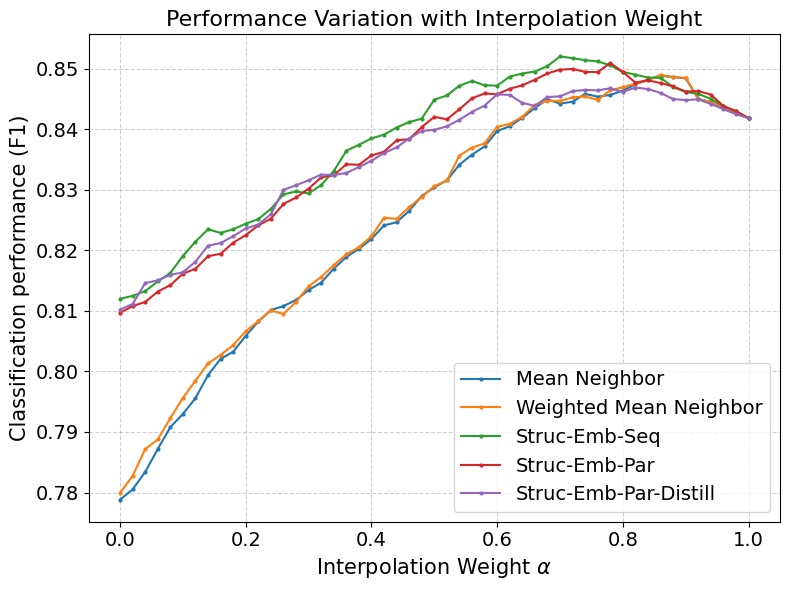

In [215]:
plot_alpha_variance(save_path="alpha_variance_0.6B_bookhis_f1.pdf")

In [216]:
np.max(acc_list_concat), alphas[np.argmax(acc_list_concat)], acc_list_concat[0], acc_list_concat[-1]

(0.8582657200811359, 0.7000000000000001, 0.821501014198783, 0.8483772819472617)

In [217]:
np.max(f1_list_concat), alphas[np.argmax(f1_list_concat)], f1_list_concat[0], f1_list_concat[-1]

(0.8520007956452845, 0.7000000000000001, 0.8119877824424032, 0.841821145451445)